# 2025-08-27 Function Errors

* Review last time

* Conditioning

* Well-posedness

* Absolute & relative errors

* Condition numbers

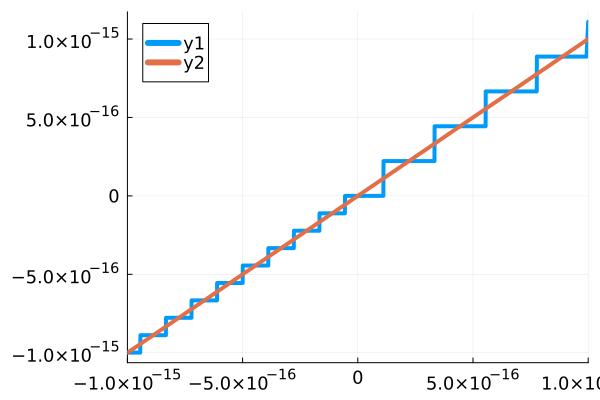

In [1]:
# Bad behavior for a function
using Plots
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

a = 1e-15
plot(x -> (1 + x) - 1, xlim=(-a, a))
plot!(x -> x)

## Machine precision

Floating point numbers do not exactly represent continuous values.

There exists $\epsilon_\text{machine}$ such that

$$ 1 \oplus x = 1 $$ for all $$ \lvert x \rvert < \epsilon_\text{machine} $$

Note: $\oplus, \ominus, \otimes, \oslash$ are the floating point arithmatic versions of $+, -, \times, /$

In [2]:
# Computing machine precision
ϵ = 1
while 1 + ϵ != 1
    ϵ = ϵ / 2
end

# And lets ask Julia what ϵ actually is
@show ϵ
@show eps();

ϵ = 1.1102230246251565e-16
eps() = 2.220446049250313e-16


In [3]:
# Number type matters!
ϵ = 1.0f0
while 1 + ϵ != 1
    ϵ = ϵ / 2
end

# And lets ask Julia what ϵ actually is
@show ϵ
@show eps(Float32);

ϵ = 5.9604645f-8
eps(Float32) = 1.1920929f-7


### Remember Taylor Series?

$$ log \left( 1 + x \right) = x - \frac{x^2}{2} + \frac{x^3}{3} - \frac{x^4}{4} + \cdots $$

Which is more accurate for computing $log \left( 1 + x \right)$?

Note: This issue shows up in Ratel!

In [4]:
# Lets compare
f1(x) = log(1 + x)
f2(x) = x - x^2 / 2 + x^3 / 3 # Taylor series
# Question - how many terms do I need here?

y1 = f1(1e-8)
y2 = f2(1e-8)

# Absolute
println("absolute error: $(y1 - y2)")

# Relative
println("relative error: $((y1 - y2) / y2)")

absolute error: -6.07747099184471e-17
relative error: -6.077471022232065e-9


## Conditioning

A function $f \left( x \right)$ is **well conditioned** if a small change in the input $x$ results in a small change in the output $f \left( x \right)$. (ToDo: We should be precise about what 'small' means here!)

The function $f \left( x \right)$ may be a simple expression:

* $f \left( x \right) = 2 x$

* $f \left( x \right) = \sqrt{x}$

* $f \left( x \right) = \text{log} \left( x \right)$

* $f \left( x \right) = x - 1$ 

The function may also be much, much more complex:

* Find the positive root of the function $t^2 + \left( 1 - x \right) t - x$

* Find the eigenvectors of the matrix
$$ A \left( x \right) = \left[ \begin{array}{cc} 1 & 1 \\ 0 & x \end{array} \right] $$

* Find the deflection of the bridge when a truck of mass $x$ drives over it

* Determine the force required to fracture a composite material as a function of the manufacturing temperature $x$

* Determine the probability of component failure as a function of the age $x$

* Project the wind power generation given the current weather observations $x$

## Specification

Do we have enough information to solve the problem?

* Some of the previous problems are fully specified

* Others involve active, ongoing research

* The function modeling reality may be more or less smooth, ore or less behaved

* Is the problem **well-posed**?

## Well-posed Problems

A problem is **well-posed** if

1) The problem has a solution

2) The solution is unique

3) The solution's behavior changes continuously with initial conditions

For 3), the variation may be continuous but rapid, and there may be real-world sources of error or variance. **Conditioning** focuses on this part of **well-possedness**.

## Test case: $e^x$

$$ e^x = \sum_{k = 0}^\infty x^k / k! $$

In [5]:
# Let's try to code this up
function myexp(x)
    sum = 1
    for k in 1:100
        sum += x^k / factorial(big(k))
    end
    sum
end
@show myexp(1) - exp(1);

myexp(1) - exp(1) = 1.445646891729250136554224997792468345749669676277240766303534163549513721620773e-16


In [6]:
# Lets pick our with ϵ in mind
function myexp(x)
    sum = 0
    term = 1
    n = 1
    while sum + term != sum
        sum += term
        term *= x / n
        n += 1
    end
    sum
end
@show myexp(1) - exp(1);

myexp(1) - exp(1) = 4.440892098500626e-16


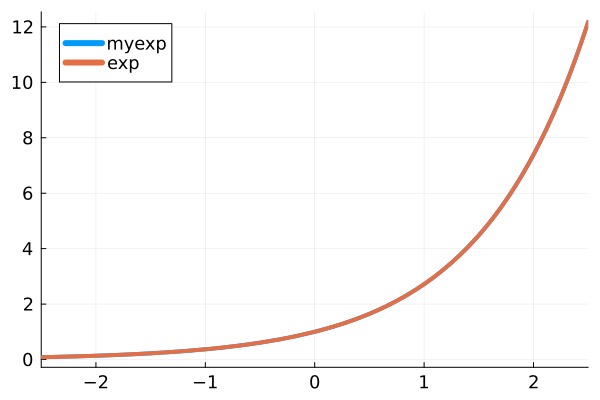

In [7]:
# looking good here
a = 2.5
plot([myexp, exp], xlims=[-a, a], label=["myexp" "exp"])

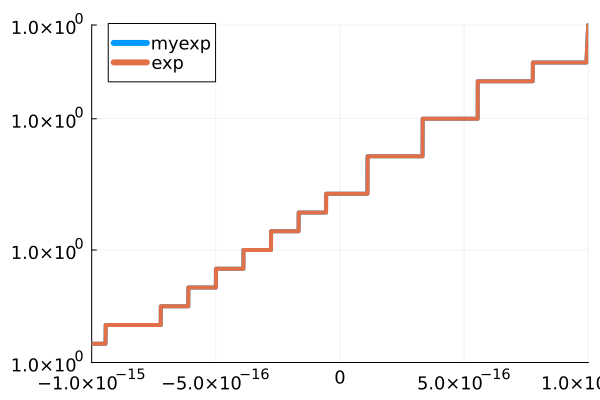

GKS: Possible loss of precision in routine SET_WINDOW


In [8]:
# but something is bad here
a = 1e-15
plot([exp, myexp], xlims=[-a, a], label=["myexp" "exp"])

## This looks fishy...

* We're investigating the output of $f \left( x \right) = e^x$ near $x = 0$

* Taylor series suggests the function is approximated by $1 + x$

* Output has error on the order of $\epsilon_\text{machine}$

## Error

### Absolute Error

$$ \lvert \tilde{f} \left( x \right) - f \left( x \right) \rvert $$

### Relative Error

$$ \frac{\lvert \tilde{f} \left( x \right) - f \left( x \right) \rvert}{\lvert f \left( x \right) \rvert} $$

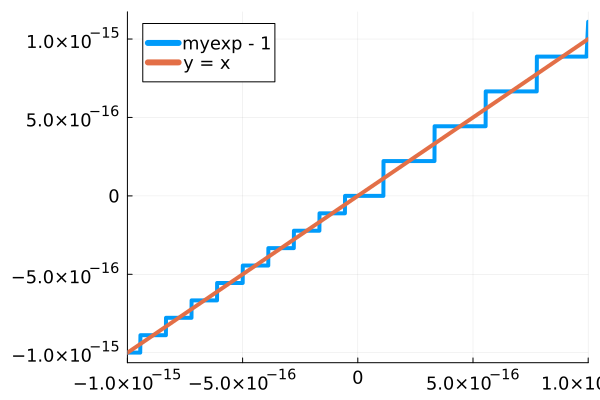

In [9]:
# What does the Taylor series show us?
a = 1e-15
plot([x -> myexp(x) - 1, x -> x], xlims=[-a, a], label=["myexp - 1" "y = x"])

In [10]:
# Checking error
a = 1e-15
@show absolute_error = abs((myexp(a) - 1) - a)
@show relative_error = abs((myexp(a) - 1) - a) / abs(a);

absolute_error = abs((myexp(a) - 1) - a) = 1.1022302462515646e-16
relative_error = abs((myexp(a) - 1) - a) / abs(a) = 0.11022302462515646


## Path forward?

* We know we should be able to recover 16 digits of accuracy

* $\text{myexp} \left( x \right) - 1$ can't find the accuracy

* Lets rebuild our algorithm from the start

In [11]:
function myexpm1(x)
    sum = 0
    term = x
    n = 2
    while sum + term != sum
        sum += term
        term *= x / n
        n += 1
    end
    sum
end
@show myexpm1(1e-15) - expm1(1e-15);

myexpm1(1.0e-15) - expm1(1.0e-15) = 0.0


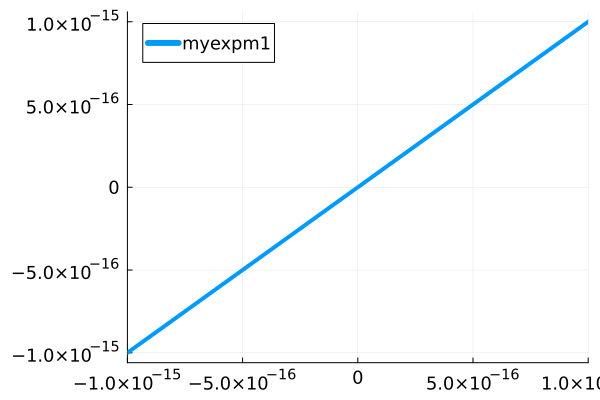

In [12]:
# Checking the plot
a = 1e-15
plot([myexpm1], xlims=[-a, a], label="myexpm1")

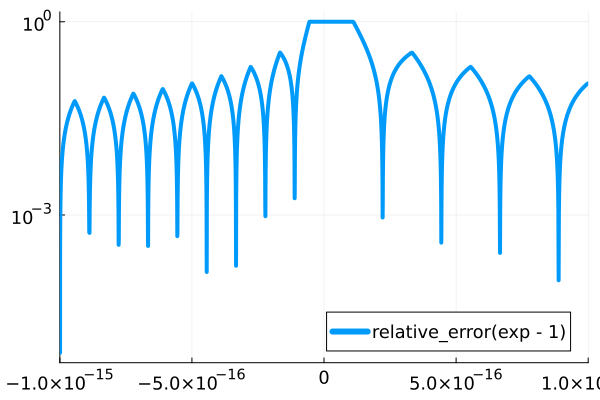

In [13]:
# Let's compute relative error
function relativeerror(f, f_true, x)
    fx = f(x)
    fx_true = f_true(x)
    max(abs(fx - fx_true) / abs(fx_true), eps())
end

# and let's plot it
bad_expm1(x) = exp(x) - 1

a = 1e-15
plot(
    x -> relativeerror(bad_expm1, expm1, x),
    yscale=:log10,
    xlims=[-a, a],
    label="relative_error(exp - 1)",
    legend=:bottomright
)

## Floating point

Floating point is *relative* (see [https://float.exposed](https://float.exposed))

If we define $fl \left ( x \right)$ as the operation that rounds to the next floating point number, then

$fl \left( x \right) = x \left( 1 + \epsilon \right)$, where $\lvert \epsilon \rvert \leq \epsilon_\text{machine}$

So relative error is small

$$ \frac{\lvert fl \left( x \right) - x \rvert}{\lvert x \rvert} \leq \epsilon_\text{machine} $$

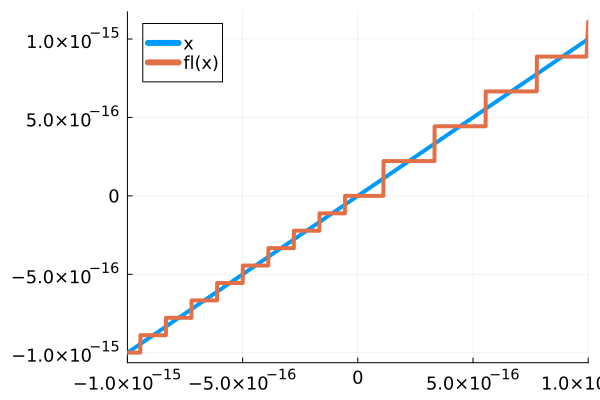

In [14]:
a = 1e-15
plot([x -> x, x -> (1 + x) - 1], xlims=[-a, a], label=["x" "fl(x)"])

## Exact arithmetic with rounded values

Floating point arithmetic is therefore exact arithmetic with rounding.

We define $\oplus, \ominus, \otimes, \oslash$ as the floating point arithmetic versions of $+, -, \times, /$.

Our relative accuracy is therefore

$$ \frac{\lvert \left( x \otimes y \right) - \left( x \times y \right) \rvert}{\lvert x \times y \rvert} \leq \epsilon_\text{machine} $$

## Composition

I would hope that this is true

$$ \frac{\lvert \left( \left( x \otimes y \right) \otimes z \right) - \left( \left( x \times y \right) \times z \right) \rvert}{\lvert \left( x \times y \right) \times z \rvert} \leq^? \epsilon_\text{machine} $$

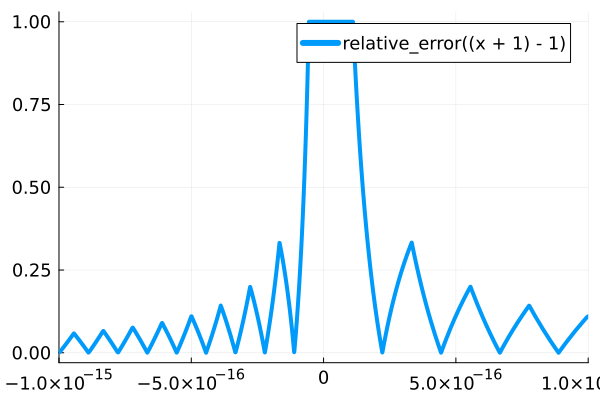

In [15]:
# Let's test it with addition
f1(x; y = 1, z = -1) = (x + y) + z;
a = 1e-15
plot(x -> relativeerror(f1, x -> x, x), xlims=(-a, a), label="relative_error((x + 1) - 1)")

## Who to blame?

1) $\text{tmp} = fl \left( x + 1 \right)$

2) $fl \left( \text{tmp} - 1 \right)$

In [16]:
# Note this 'gotcha' with big floats
@show big(1e-15); # First float, then bigFloat
@show BigFloat("1e-15"); # bigFloat from the start

big(1.0e-15) = 1.000000000000000077705399876661079238307185601195015145492561714490875601768494e-15
BigFloat("1e-15") = 1.000000000000000000000000000000000000000000000000000000000000000000000000000003e-15


In [17]:
# 1) tmp = fl(x + 1)
tmp = 1e-15 + 1
tmp_big = BigFloat(1e-15) + 1
@show relative_error = abs(tmp - tmp_big) / abs(tmp_big);

relative_error = abs(tmp - tmp_big) / abs(tmp_big) = 1.102230246251563524952071662733800140614440125894379682676737388538642032894338e-16


In [18]:
# 2) fl(tmp - 1)
result = tmp - 1
result_big = big(tmp) - 1
@show relative_error = abs(result - result_big) / abs(result_big);

relative_error = abs(result - result_big) / abs(result_big) = 0.0


So, which part is to blame?

Step 1 has the rounding. Step 2 is exact.

But Step 2 represents *subtractive cancellation* and is the loss of accuracy in the final result.

## Conditioning

So which functions cause small errors to grow?

Consider a function $f : X \rightarrow Y$.
The **condition number** is defined as

$$ \hat{\kappa} = \lim_{\delta \rightarrow 0} \max_{\lvert \delta x \rvert < \delta} \frac{f \left( x + \delta x \right) - f \left( x \right)}{\lvert \delta x \rvert} = \max_{\delta x} \frac{\lvert \delta f \rvert}{\lvert \delta x \rvert} $$

If $f$ is differentiable, then $\hat{\kappa} = \lvert f' \left( x \right) \lvert$.

Floating point numbers offer relative accuracy, so we define the **relative condition number** as

$$ \kappa = \max_{\delta x} \frac{\lvert \delta f \rvert / \lvert f \rvert}{\lvert \delta x \rvert / \lvert x \rvert} = \max_{\delta x} \frac{\lvert \delta f \rvert / \lvert \delta x \rvert}{\lvert f \rvert / \vert x \rvert} $$

If $f$ is differentiable, then $\kappa = \left\lvert f' \left( x \right) \right\rvert \frac{\lvert x \rvert}{\lvert f \rvert}$.